# Dataset Complexity Analysis

This notebook explores the Random Forest complexity metrics contained in ``forest_report.json``. It replicates the logic used by ``sort_datasets_by_complexity.py`` and enriches it with tabular views and visualisations to better understand how each dataset compares.

## Load the dataset report

The JSON report is generated by ``dataset_forest_report.py``. Each entry contains metadata about the dataset alongside summary statistics for the optimised Random Forest model.

In [1]:
from __future__ import annotations

from pathlib import Path
from typing import Any, Mapping
import json

import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
REPORT_PATH = Path('forest_report.json')
REPORT_PATH.resolve()

WindowsPath('C:/Users/danie/Projects/GitHub/icde/forest_report.json')

In [2]:
with REPORT_PATH.open('r', encoding='utf-8') as handle:
    report_data: list[dict[str, Any]] = json.load(handle)

len(report_data)

87

## Build a summary table

We reuse the Random Forest estimator counts reported in ``forest_report.json`` to build a sortable summary. This mirrors the CLI behaviour after switching to raw estimator counts.

In [3]:
def to_int(value: Any | None) -> int | None:
    try:
        return int(value)
    except (TypeError, ValueError):
        return None


def to_float(value: Any | None) -> float | None:
    try:
        return float(value)
    except (TypeError, ValueError):
        return None


def extract_metadata(entry: Mapping[str, Any]) -> dict[str, Any]:
    metadata = entry.get('metadata')
    if not isinstance(metadata, Mapping):
        metadata = {}

    statistics = entry.get('forest_statistics')
    if not isinstance(statistics, Mapping):
        statistics = {}

    dataset = str(entry.get('dataset', '')) or '<unknown>'

    return {
        'dataset': dataset,
        'n_estimators': to_int(statistics.get('n_estimators')),
        'series_length': to_int(metadata.get('series_length')),
        'train_size': to_int(metadata.get('train_size')),
        'test_size': to_int(metadata.get('test_size')),
        'avg_depth': to_float(statistics.get('avg_depth')),
        'avg_leaves': to_float(statistics.get('avg_leaves')),
        'avg_nodes': to_float(statistics.get('avg_nodes')),
    }


summary_rows = [extract_metadata(entry) for entry in report_data]
summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values(
    ['n_estimators', 'series_length', 'dataset'],
    ascending=[True, True, True],
    na_position='last',
).reset_index(drop=True)
summary_df.head()


,dataset,n_estimators,series_length,train_size,test_size,avg_depth,avg_leaves,avg_nodes
0,MelbournePedestrian,10.0,24,1138,2319,9.3,40.2,79.4
1,MiddlePhalanxOutlineCorrect,10.0,80,600,291,8.0,35.6,70.2
2,ElectricDevices,10.0,96,8926,7711,26.6,360.9,720.8
3,Wafer,10.0,152,1000,6164,6.8,13.2,25.4
4,ChlorineConcentration,10.0,166,467,3840,15.1,39.4,77.8


## Full dataset ranking

The full table mirrors the CLI output but includes additional metadata for reference.

In [4]:
styled_summary = summary_df.style.format({
    'n_estimators': '{:,}'.format,
    'avg_depth': '{:.2f}'.format,
    'avg_leaves': '{:,.2f}'.format,
    'avg_nodes': '{:,.2f}'.format,
})
styled_summary

,dataset,n_estimators,series_length,train_size,test_size,avg_depth,avg_leaves,avg_nodes
0,MelbournePedestrian,10.0,24,1138,2319,9.30,40.20,79.40
1,MiddlePhalanxOutlineCorrect,10.0,80,600,291,8.00,35.60,70.20
2,ElectricDevices,10.0,96,8926,7711,26.60,360.90,720.80
3,Wafer,10.0,152,1000,6164,6.80,13.20,25.40
4,ChlorineConcentration,10.0,166,467,3840,15.10,39.40,77.80
5,Wine,10.0,234,57,54,2.60,4.40,7.80
6,FordA,10.0,500,3601,1320,10.30,30.00,59.00
7,FordB,10.0,500,3636,810,12.20,30.00,59.00
8,ScreenType,10.0,720,375,375,0.20,1.20,1.40
9,SonyAIBORobotSurface1,17.0,70,20,601,1.65,2.71,4.41


## Smallest datasets by estimator count

A horizontal bar chart provides a compact overview of the datasets with the smallest ensembles.

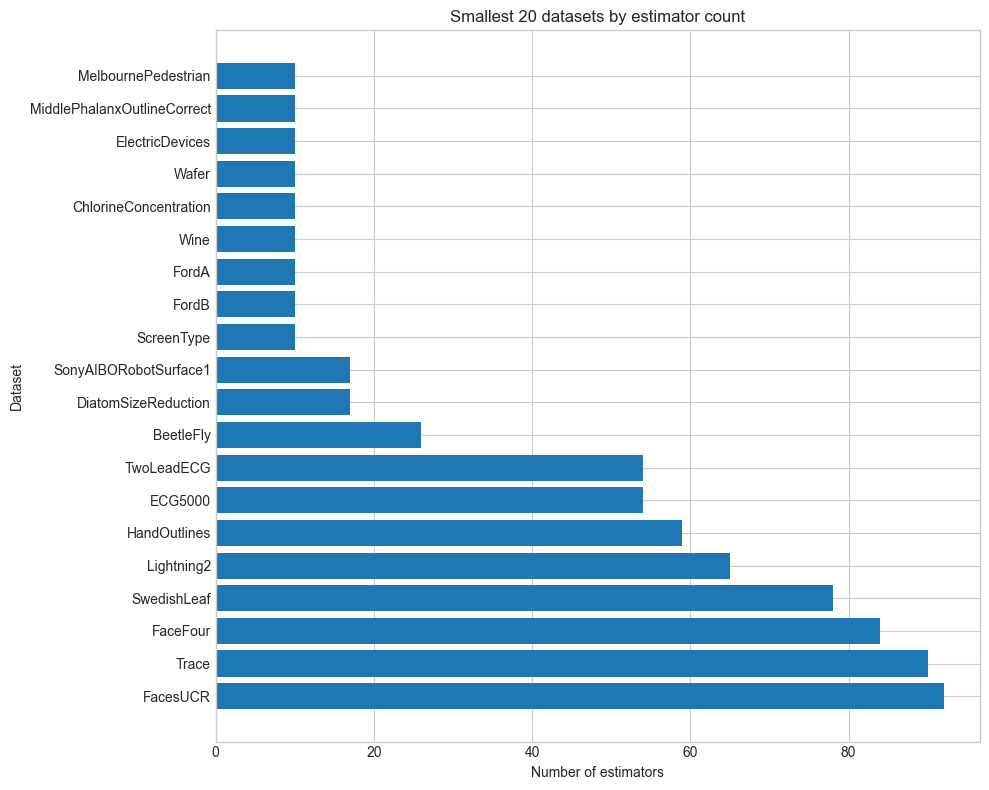

In [5]:
smallest_n = 20
least_complex = summary_df.head(smallest_n)
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(least_complex['dataset'], least_complex['n_estimators'], color='#1f77b4')
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Dataset')
ax.set_title(f'Smallest {smallest_n} datasets by estimator count')
ax.invert_yaxis()
plt.tight_layout()
plt.show()


## Estimator count vs. series length

The scatter plot below highlights whether longer time series also require larger ensembles.

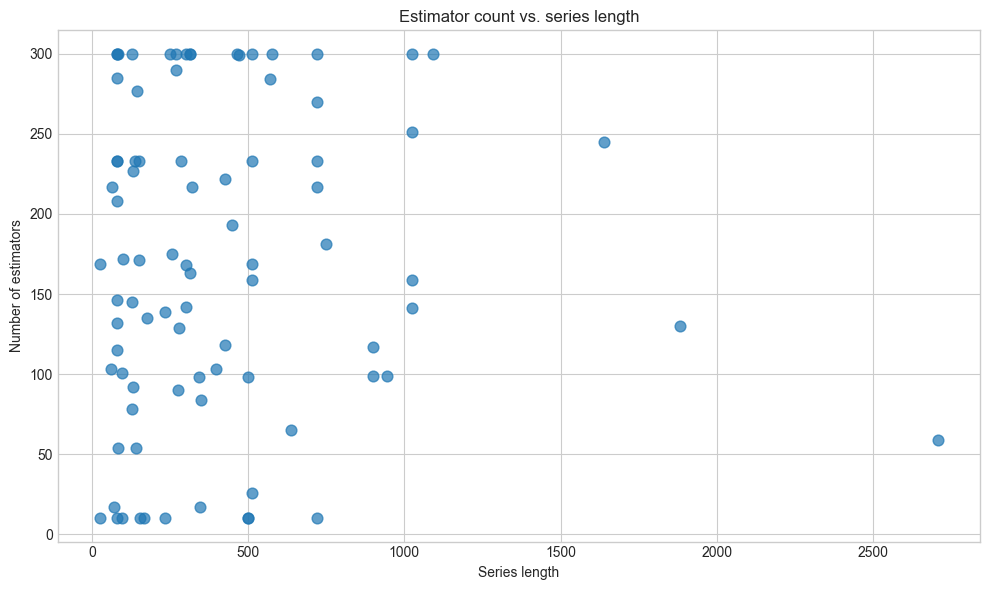

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(summary_df['series_length'], summary_df['n_estimators'], s=60, alpha=0.7)
ax.set_xlabel('Series length')
ax.set_ylabel('Number of estimators')
ax.set_title('Estimator count vs. series length')
plt.tight_layout()
plt.show()

## Distribution of estimator counts

Finally, a histogram shows how estimator usage varies across datasets.

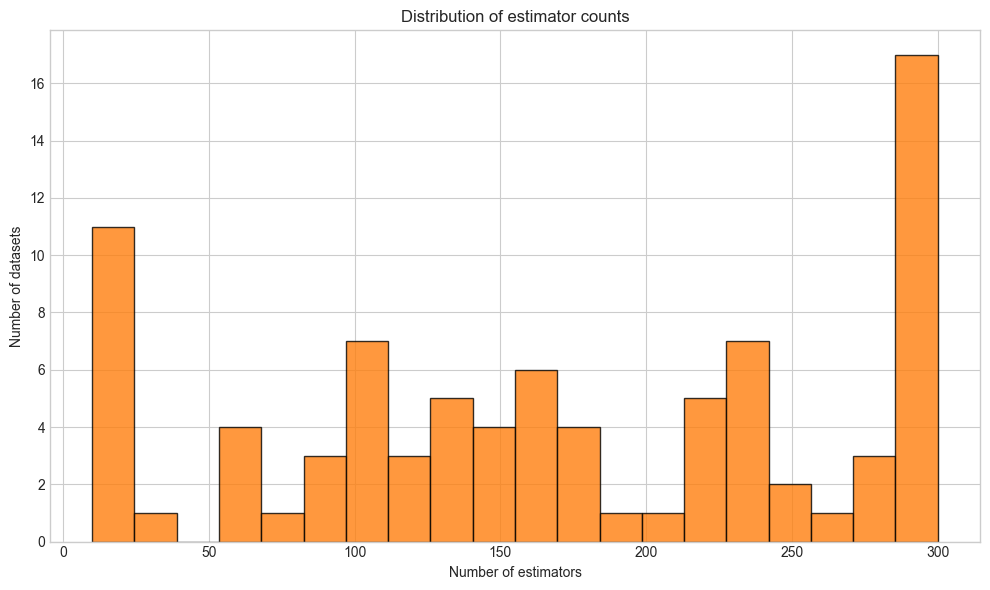

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(summary_df['n_estimators'], bins=20, color='#ff7f0e', edgecolor='black', alpha=0.8)
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Number of datasets')
ax.set_title('Distribution of estimator counts')
plt.tight_layout()
plt.show()